### Assignment2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import time

In [53]:
#load cifar10
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),          
    transforms.RandomHorizontalFlip(),               
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    
])
transform = transforms.Compose([
    transforms.ToTensor(),           
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    
])

#train validation set
trainval = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
#split trainval into trainset and valset 
trainset,valset = torch.utils.data.random_split(trainval, [0.9, 0.1])
#trainloader and valloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)
trainloader2 = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)

valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=True, num_workers=0)
#test set
testset = trainval = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#testloader
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)
#classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
#cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
def train_plot(num_epochs,model,criterion,optimizer,trainloader,valloader):
    start_time = time.time()
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        epoch_start = time.time()
        #training
        model.train()  
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # calculate trainset's accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        #validating
        model.eval() 
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():  
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                #calculate valset's accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(valloader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        epoch_time = time.time()-epoch_start
        # print
        print(f"Epoch [{epoch+1}/{num_epochs}], Time:{epoch_time:.2f}s, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    total_time = time.time()-start_time
    print(f"Total Time:{total_time:.2f}s")
    # plot loss curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # plot accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()


In [31]:
def test_accuracy(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Accuracy: {100 * correct / total:.2f}%")

In [5]:
#cnn model
model_vgg16 = models.vgg16(weights=None)  
model_vgg16.classifier[6] = nn.Linear(4096, 10) 
model_vgg16 = model_vgg16.to(device)  

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg16.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

Epoch [1/20], Time:52.86s, Train Loss: 1.8459, Train Accuracy: 28.08%, Validation Loss: 1.7113, Validation Accuracy: 38.82%
Epoch [2/20], Time:51.48s, Train Loss: 1.3401, Train Accuracy: 50.62%, Validation Loss: 1.1713, Validation Accuracy: 58.14%
Epoch [3/20], Time:51.55s, Train Loss: 1.0339, Train Accuracy: 63.30%, Validation Loss: 0.9174, Validation Accuracy: 68.56%
Epoch [4/20], Time:51.55s, Train Loss: 0.8432, Train Accuracy: 70.88%, Validation Loss: 0.8038, Validation Accuracy: 72.98%
Epoch [5/20], Time:51.53s, Train Loss: 0.7010, Train Accuracy: 76.38%, Validation Loss: 0.7415, Validation Accuracy: 74.72%
Epoch [6/20], Time:51.55s, Train Loss: 0.5933, Train Accuracy: 79.88%, Validation Loss: 0.6941, Validation Accuracy: 76.86%
Epoch [7/20], Time:51.51s, Train Loss: 0.5027, Train Accuracy: 83.04%, Validation Loss: 0.6359, Validation Accuracy: 78.86%
Epoch [8/20], Time:51.53s, Train Loss: 0.4218, Train Accuracy: 85.85%, Validation Loss: 0.6707, Validation Accuracy: 78.30%
Epoch [9

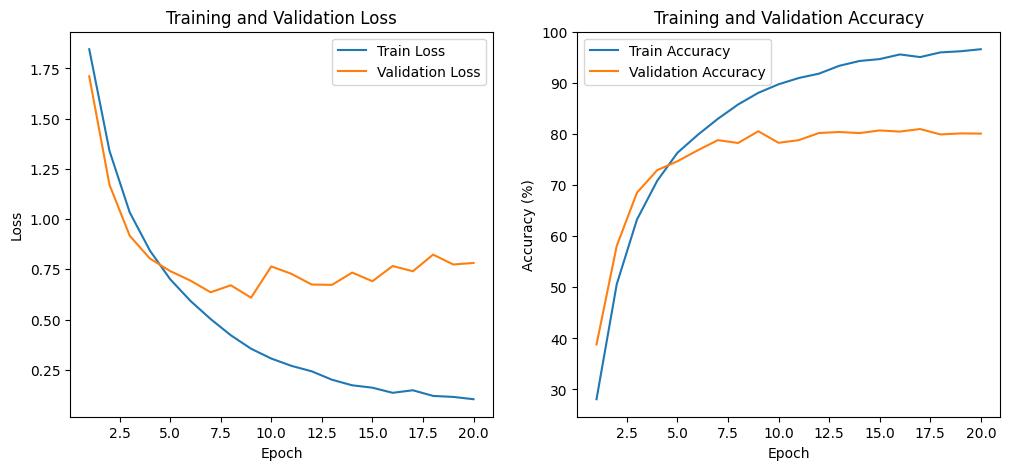

In [7]:
train_plot(20,model_vgg16,criterion,optimizer,trainloader,valloader)

In [8]:
model_vgg16.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 81.31%


In [9]:
model_vgg16_mod1 = models.vgg16(weights=None) 
model_vgg16_mod1.classifier[6] = nn.Linear(4096, 10) 
model_vgg16_mod1 = model_vgg16_mod1.to(device)  
criterion_mod1 = nn.CrossEntropyLoss()
optimizer_mod1 = optim.SGD(model_vgg16_mod1.parameters(), lr=0.02, momentum=0.9, weight_decay=0.0015)


Epoch [1/20], Time:51.38s, Train Loss: 1.9582, Train Accuracy: 22.63%, Validation Loss: 1.7775, Validation Accuracy: 28.98%
Epoch [2/20], Time:51.45s, Train Loss: 1.5740, Train Accuracy: 39.56%, Validation Loss: 1.3380, Validation Accuracy: 50.60%
Epoch [3/20], Time:51.39s, Train Loss: 1.2569, Train Accuracy: 55.00%, Validation Loss: 1.1577, Validation Accuracy: 60.22%
Epoch [4/20], Time:51.41s, Train Loss: 1.0506, Train Accuracy: 63.86%, Validation Loss: 0.9661, Validation Accuracy: 66.56%
Epoch [5/20], Time:51.36s, Train Loss: 0.9155, Train Accuracy: 69.12%, Validation Loss: 0.9526, Validation Accuracy: 69.62%
Epoch [6/20], Time:51.37s, Train Loss: 0.8252, Train Accuracy: 72.76%, Validation Loss: 0.9349, Validation Accuracy: 69.16%
Epoch [7/20], Time:51.34s, Train Loss: 0.7669, Train Accuracy: 74.98%, Validation Loss: 0.8749, Validation Accuracy: 72.46%
Epoch [8/20], Time:51.35s, Train Loss: 0.6931, Train Accuracy: 77.48%, Validation Loss: 0.8331, Validation Accuracy: 72.96%
Epoch [9

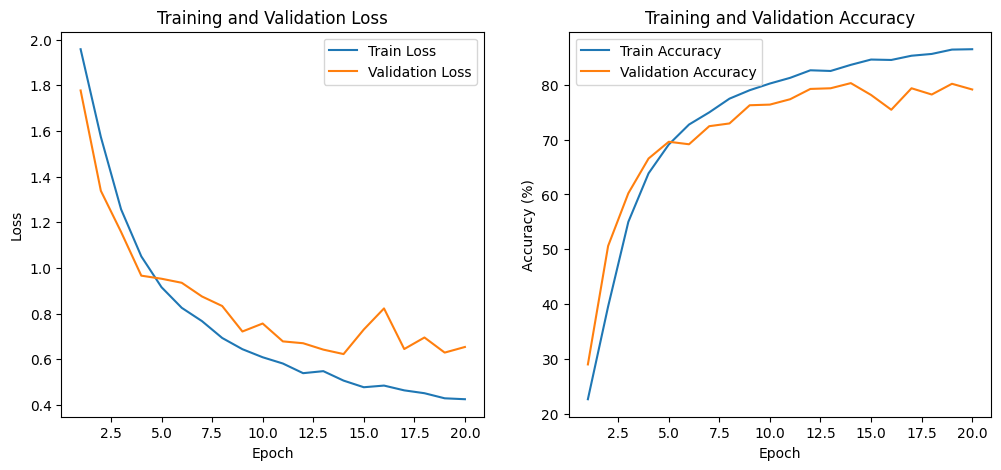

In [10]:
train_plot(20,model_vgg16_mod1,criterion_mod1,optimizer_mod1,trainloader,valloader)

In [11]:
model_vgg16_mod1.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg16_mod1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 79.28%


In [12]:
model_vgg16_mod2 = models.vgg16(weights=None) 
model_vgg16_mod2.classifier[6] = nn.Linear(4096, 10) 
model_vgg16_mod2 = model_vgg16_mod2.to(device)  
criterion_mod2 = nn.CrossEntropyLoss()
optimizer_mod2 = optim.SGD(model_vgg16_mod2.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0015)

Epoch [1/20], Time:75.47s, Train Loss: 2.0032, Train Accuracy: 23.20%, Validation Loss: 1.7445, Validation Accuracy: 32.58%
Epoch [2/20], Time:76.24s, Train Loss: 1.5312, Train Accuracy: 42.78%, Validation Loss: 1.3177, Validation Accuracy: 52.04%
Epoch [3/20], Time:77.07s, Train Loss: 1.2554, Train Accuracy: 54.06%, Validation Loss: 1.1431, Validation Accuracy: 58.20%
Epoch [4/20], Time:77.22s, Train Loss: 1.0537, Train Accuracy: 61.70%, Validation Loss: 0.9849, Validation Accuracy: 64.68%
Epoch [5/20], Time:76.84s, Train Loss: 0.9070, Train Accuracy: 67.45%, Validation Loss: 0.8598, Validation Accuracy: 69.56%
Epoch [6/20], Time:76.83s, Train Loss: 0.7806, Train Accuracy: 72.48%, Validation Loss: 0.7648, Validation Accuracy: 72.84%
Epoch [7/20], Time:76.77s, Train Loss: 0.6750, Train Accuracy: 76.08%, Validation Loss: 0.7406, Validation Accuracy: 74.34%
Epoch [8/20], Time:76.76s, Train Loss: 0.5814, Train Accuracy: 79.69%, Validation Loss: 0.7123, Validation Accuracy: 75.52%
Epoch [9

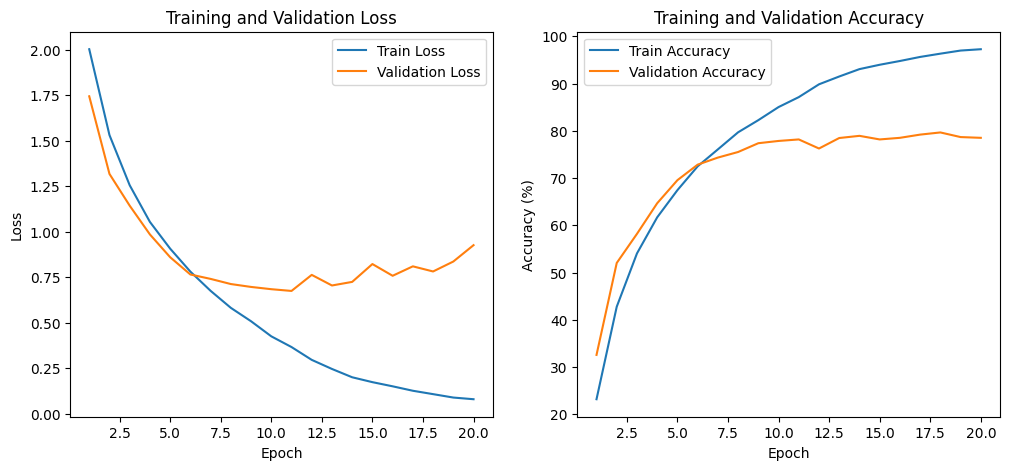

In [13]:
train_plot(20,model_vgg16_mod2,criterion_mod2,optimizer_mod2,trainloader2,valloader)

In [23]:
model_vgg16_mod2.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg16_mod2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 77.24%


In [18]:
model_vgg16_mod3 = models.vgg16(weights=None) 
model_vgg16_mod3.classifier[6] = nn.Linear(4096, 10) 
model_vgg16_mod3 = model_vgg16_mod3.to(device)  
criterion_mod3 = nn.CrossEntropyLoss()
optimizer_mod3 = optim.SGD(model_vgg16_mod3.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0025)

Epoch [1/20], Time:55.82s, Train Loss: 1.9102, Train Accuracy: 25.36%, Validation Loss: 1.8578, Validation Accuracy: 31.56%
Epoch [2/20], Time:52.24s, Train Loss: 1.4163, Train Accuracy: 46.96%, Validation Loss: 1.2937, Validation Accuracy: 53.24%
Epoch [3/20], Time:55.69s, Train Loss: 1.1182, Train Accuracy: 59.94%, Validation Loss: 1.1047, Validation Accuracy: 62.04%
Epoch [4/20], Time:51.64s, Train Loss: 0.9488, Train Accuracy: 66.58%, Validation Loss: 0.8573, Validation Accuracy: 70.00%
Epoch [5/20], Time:51.77s, Train Loss: 0.8211, Train Accuracy: 71.86%, Validation Loss: 0.8293, Validation Accuracy: 71.06%
Epoch [6/20], Time:51.65s, Train Loss: 0.7305, Train Accuracy: 75.36%, Validation Loss: 0.7613, Validation Accuracy: 74.22%
Epoch [7/20], Time:51.64s, Train Loss: 0.6636, Train Accuracy: 77.87%, Validation Loss: 0.7012, Validation Accuracy: 76.10%
Epoch [8/20], Time:51.74s, Train Loss: 0.6071, Train Accuracy: 79.74%, Validation Loss: 0.7017, Validation Accuracy: 76.64%
Epoch [9

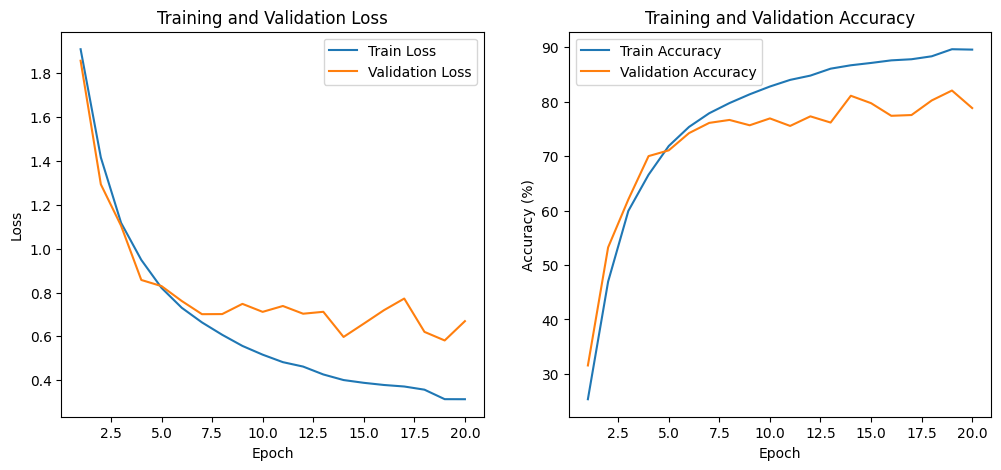

In [19]:
train_plot(20,model_vgg16_mod3,criterion_mod3,optimizer_mod3,trainloader,valloader)

In [22]:
model_vgg16_mod3.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg16_mod3(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 78.53%


In [28]:
model_resnet = models.resnet18(weights=None)  # 可以选择 resnet18, resnet34 等其他版本
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 10)  # 修改输出层为 CIFAR-10 的 10 个类别
model_resnet = model_resnet.to(device)
optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

Epoch [1/20], Time:18.69s, Train Loss: 1.9386, Train Accuracy: 35.47%, Validation Loss: 1.4424, Validation Accuracy: 47.78%
Epoch [2/20], Time:18.52s, Train Loss: 1.3576, Train Accuracy: 51.10%, Validation Loss: 1.2404, Validation Accuracy: 56.56%
Epoch [3/20], Time:18.78s, Train Loss: 1.1422, Train Accuracy: 59.69%, Validation Loss: 1.1193, Validation Accuracy: 60.82%
Epoch [4/20], Time:18.97s, Train Loss: 1.0704, Train Accuracy: 62.29%, Validation Loss: 0.9886, Validation Accuracy: 65.90%
Epoch [5/20], Time:18.81s, Train Loss: 0.8888, Train Accuracy: 68.89%, Validation Loss: 1.1555, Validation Accuracy: 61.98%
Epoch [6/20], Time:18.96s, Train Loss: 0.8667, Train Accuracy: 69.96%, Validation Loss: 0.8924, Validation Accuracy: 68.30%
Epoch [7/20], Time:18.85s, Train Loss: 0.7248, Train Accuracy: 74.96%, Validation Loss: 0.8012, Validation Accuracy: 72.76%
Epoch [8/20], Time:18.86s, Train Loss: 0.6570, Train Accuracy: 77.36%, Validation Loss: 0.8297, Validation Accuracy: 72.12%
Epoch [9

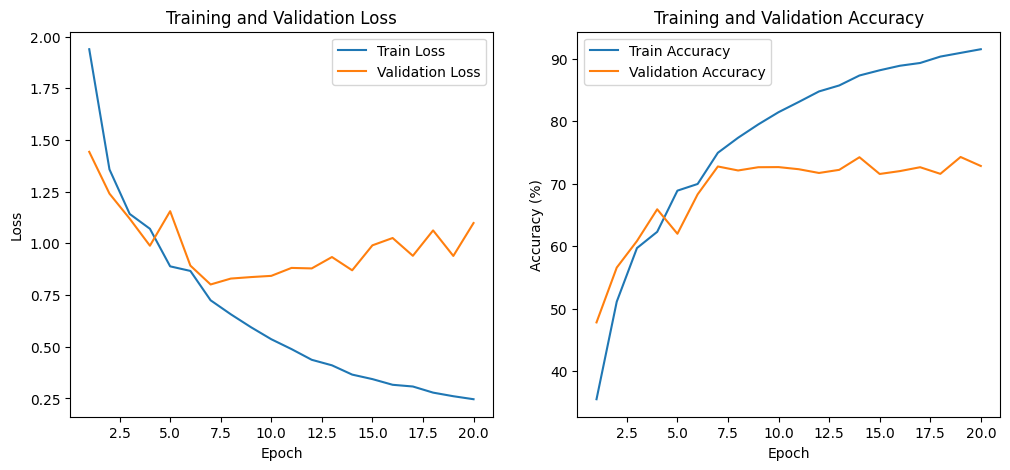

In [29]:
train_plot(20,model_resnet,criterion,optimizer_resnet,trainloader,valloader)

In [32]:
test_accuracy(model_resnet)

Accuracy: 72.63%


In [54]:
model_resnet2 = models.resnet18(weights=None)  # 可以选择 resnet18, resnet34 等其他版本
model_resnet2.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
model_resnet2.fc = nn.Linear(512, 10)  # 修改输出层为 CIFAR-10 的 10 个类别
model_resnet2 = model_resnet2.to(device)
optimizer_resnet2 = optim.SGD(model_resnet2.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

Epoch [1/20], Time:26.42s, Train Loss: 1.5189, Train Accuracy: 45.35%, Validation Loss: 1.3763, Validation Accuracy: 51.62%
Epoch [2/20], Time:26.41s, Train Loss: 1.0907, Train Accuracy: 61.40%, Validation Loss: 1.0250, Validation Accuracy: 64.06%
Epoch [3/20], Time:26.16s, Train Loss: 0.8983, Train Accuracy: 68.74%, Validation Loss: 0.9269, Validation Accuracy: 68.28%
Epoch [4/20], Time:26.31s, Train Loss: 0.7891, Train Accuracy: 72.51%, Validation Loss: 0.9425, Validation Accuracy: 68.42%
Epoch [5/20], Time:26.40s, Train Loss: 0.7059, Train Accuracy: 75.46%, Validation Loss: 0.8283, Validation Accuracy: 72.24%
Epoch [6/20], Time:26.63s, Train Loss: 0.6447, Train Accuracy: 77.60%, Validation Loss: 0.7337, Validation Accuracy: 74.82%
Epoch [7/20], Time:26.40s, Train Loss: 0.6014, Train Accuracy: 79.30%, Validation Loss: 0.6649, Validation Accuracy: 76.72%
Epoch [8/20], Time:26.51s, Train Loss: 0.5729, Train Accuracy: 80.28%, Validation Loss: 0.6179, Validation Accuracy: 78.38%
Epoch [9

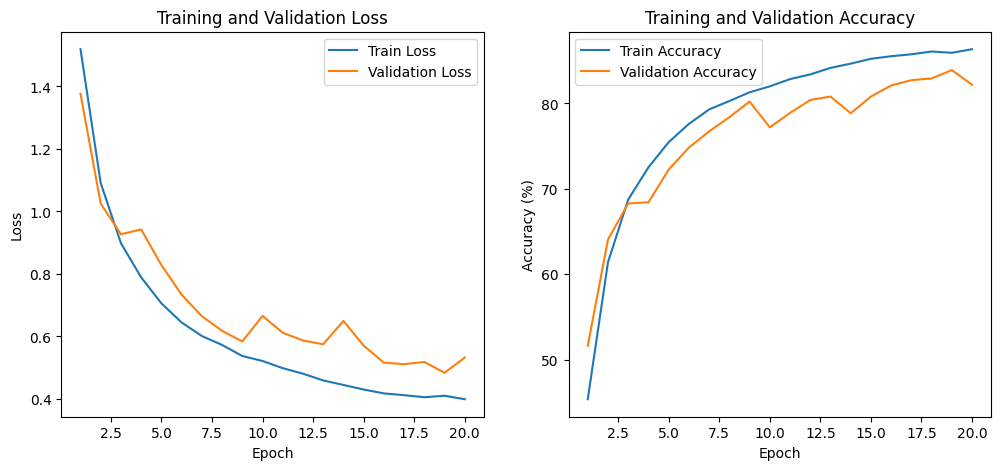

In [55]:
train_plot(20,model_resnet2,criterion,optimizer_resnet2,trainloader,valloader)

In [56]:
test_accuracy(model_resnet2)

Accuracy: 83.60%
